# ***Building Image Caption Generator Using LSTM***

## ***1-Importing packages and Libraries***

In [5]:
from tensorflow.keras.layers import Input , Dense , Embedding , LSTM , Dropout , add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from nltk.stem.snowball import stopwords
from tensorflow.keras.models import Model
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import tensorflow_text as text
import tensorflow_hub as hub
import tensorflow as tf
from PIL import Image
import numpy as np
import seaborn
import random
import pickle
#import spacy
import nltk
import gzip
import cv2
import os
import re
import json
#nltk.download("all")

In [ ]:
! python -m spacy download en_core_web_md

In [1]:
cd "C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\saved_models"

C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\saved_models


## ***2-Preprocessing text***

* Punctuation removal







In [2]:
def remove_punc(text) :
  return re.sub(r'[^\w\s]','',text)

* Lowercasing

In [3]:
def to_lower_case(text) :
  return text.lower()

* Removing Stopwords

In [ ]:
stopwords_list = stopwords.words('english')
def remove_stopwords(text) :
  text_words = [word for word in text.split() if ((word not in stopwords_list) and (len(word) > 2))]
  text = " ".join(text_words)
  return text

* Removing numbers

In [5]:
def remove_numbers(text) :
  return re.sub(r'[0-9]','',text)

* Removing multiple whitespaces

In [58]:
def remove_multiple_spaces(text) :
  return re.sub(' +',' ',text).strip()

In [59]:
# gathering all the text cleaning steps in one function
def clean_text(text) :
  text = remove_punc(text)
  text = to_lower_case(text)
  text = remove_stopwords(text)
  text = remove_numbers(text)
  text = remove_multiple_spaces(text)
  return text

## ***3-Preprocessing data***

In [6]:
def read_file(path) : 
  with open(path, 'r') as file :
    return file.read().split('\n')

In [7]:
# converting image_captions data into dict where keys = images and values = captions 
def get_data_dictionary(data) :
  descriptions = {}
  for line in data :
    image_name , caption = line.split('\t')
    if image_name[:-2] in descriptions.keys() :
      descriptions[image_name[:-2]].append(caption)
    else :
      descriptions[image_name[:-2]] = [caption]
  return descriptions

In [8]:
# using predefined text preprocessing functions to clean the captions text
def clean_captions(descriptions) :
  for image in descriptions.keys() :
    for index , caption in enumerate(descriptions[image]) :
      descriptions[image][index] = clean_text(caption)
  return descriptions

In [9]:
# writing down data dictionary into external file
def write_file(path,data) :
  lines = []
  for image in data.keys() :
    for caption in data[image] :
      lines.append(image+'\t'+caption)
  lines = '\n'.join(lines)
  with open(path,'w') as file :
    file.write(lines)

In [ ]:
data = read_file("C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\Flickr8k.token.txt")
descriptions = get_data_dictionary(data)
descriptions = clean_captions(descriptions)
path = os.path.join("C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master",'cleaned_data.txt')
write_file(path,descriptions)

## ***4-Extracting Images Features***

In [10]:
# importing VGG16 model without the output layer
features_extractor = VGG16()
features_extractor = Model(inputs = features_extractor.inputs  , outputs =  features_extractor.layers[-2].output)
features_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [11]:
images_path = r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\flickr30k_images"
images_names = os.listdir(images_path)

In [12]:
# Using preptrained model to extract images features and building dict where key:images_names and values:images_features
def preprocess_image(model,images_path,images_list) :
  features = {}
  for img in images_list :
    path = os.path.join(images_path,img)
    image = Image.open(path)
    image = image.resize((224,224))
    image = np.expand_dims(image, axis = 0)
    image = image / 127.5
    image = image -1
    feature = model.predict(image)
    features[img] = feature
  return features

In [ ]:
features = preprocess_image(features_extractor,images_path,images_names)
path = os.path.join(r'C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master','images_features.bin')

# saving images_features dict into .bin file
pickle.dump(features,open(path,'wb'))

In [4]:
# features_extractor.save("features_extractor.h5")

## ***5-Loading prepared files***

In [13]:
# adding <start> and <end> to each caption
def load_tokens(path,images) :
  lines = read_file(path)
  tokens = {}
  for line in lines :
    img , caption = line.split('\t')
    if img in images :
      if img not in tokens.keys() :
        tokens[img] = []
      tokens[img].append("<start> "+caption+" <end>")
  return tokens

In [14]:
# listing all available images
def list_images(path) :
   all_images = []
   lines = read_file(path)
   for line in lines :
    img , caption = line.split('\t')
    if img not in all_images :
       all_images.append(img)
   return all_images

all_images_list = list_images("C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\cleaned_data.txt")

## ***6-Splitting Images into Training, Validation & Testing sets***

In [15]:
# training_images , testing_images = train_test_split(all_images_list , test_size = .1 , shuffle = True)
# cross_validation_images , testing_images = train_test_split(testing_images , test_size = .5 , shuffle = True)

In [16]:
def write_list_to_file(input_list, file_name):
    with open(file_name, "w") as file:
        for item in input_list:
            file.write(str(item) + "\n")

In [17]:
# write_list_to_file(training_images, 'training_images_list.txt')
# write_list_to_file(cross_validation_images, 'cross_validation_images_list.txt')
# write_list_to_file(testing_images, 'testing_images_list.txt')

In [18]:
import pickle
training_images = read_file(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\training_images_list.txt")
# loading training images_captions dict
training_tokens = load_tokens(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\cleaned_data.txt",training_images)
# loading extracted images features
features = pickle.load(open(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\images_features.bin",'rb'))

## ***7-Building text vectorization model***

In [19]:
# extracting all captions into one list
def fetch_captions(tokens) :
  captions = []
  for caps in tokens.values() :
    [captions.append(cap) for cap in caps]
  return captions

In [20]:
captions = fetch_captions(training_tokens)

In [21]:
sentences_length = []
for caption in captions :
  sentences_length.append(len(caption.split()))

max_length = max(sentences_length)
full_text = ' '.join(captions)

In [22]:
text_dataset = tf.data.Dataset.from_tensor_slices(captions)

# preparing TextVectorization layer to be used to tokenize captions
vectorize_layer = TextVectorization(output_mode = 'int' )
vectorize_layer.adapt(text_dataset)

# building vocab using TextVectorization layer
vocabulary = list(vectorize_layer.get_vocabulary())
vocab_size = vectorize_layer.vocabulary_size()

In [23]:
# Pickle the config and weights
pickle.dump({'config': vectorize_layer.get_config(),'weights': vectorize_layer.get_weights()}, open("tv_layer.pkl", "wb"))

In [20]:
# tokenizing captions and saving it back to dict where keys:images and values:sequences
training_images_sequences = {}
i = 0
for img , captions in training_tokens.items():
    training_images_sequences[img] = []
    for caption in captions :
        sequence =  vectorize_layer(tf.constant([caption])).numpy().tolist()[0]
        training_images_sequences[img].append(sequence)

In [21]:
# with open('training_images_sequences.json', 'w') as f:
#     # Serialize the dictionary to JSON and write it to the file
#     json.dump(training_images_sequences, f)

In [22]:
with open(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\training_images_sequences.json", 'r') as f:
    # Load the JSON data from the file and deserialize it to a Python object
    training_tokens = json.load(f)

## ***8-Building data generator***

In [23]:
def data_generator(tokens_keys,tokens,features,vocab_size,max_length,batch_size) :
    input_1 , input_2 , output = [] , [] , []
    n = 0
    while 1 :
        for img in tokens_keys :
            sequences = tokens[img]
            n += 1
            if img in features.keys() :
                feature = features[img][0]
                for sequence in sequences :
                    for index in range(1,len(sequence)) :
                        input_b = sequence[:index]
                        input_b = pad_sequences([input_b], maxlen = max_length, padding='post')[0]
                        output_w = sequence[index]
                        output_w = to_categorical([output_w],num_classes=vocab_size)[0]
                        input_1.append(feature)
                        input_2.append(input_b)
                        output.append(output_w)
            
            if n == batch_size :
                try :
                    input_1, input_2 , output = np.array(input_1), np.array(input_2), np.array(output)
                    yield [input_1,input_2],output
                    input_1 , input_2 , output = [] , [] , []
                    n = 0
                except :
                    print("Skipped")
                    input_1 , input_2 , output = [] , [] , []
                    n = 0

## ***9-Building Captioning Model***

In [24]:
no_of_features = 4096
  
def build_model(no_of_features,max_length,output_size,learning_rate) :

# images features model path
  input_img = Input(shape=(no_of_features,))
  cnn_layer1 = Dropout(.4)(input_img)
  cnn_layer2 = Dense(256, activation = 'relu')(cnn_layer1)
  
# sequences path
  input_seq = Input(shape=(max_length,))
  lstm_layer1 = Embedding(output_size,300,input_length = max_length , mask_zero = True )(input_seq)
  lstm_layer2 = Dropout(.4) (lstm_layer1)
  lstm_layer3 = LSTM(256,activation='tanh') (lstm_layer2)

  merging_layer = add([cnn_layer2,lstm_layer3])
  final_dense = Dense(256 , activation ='relu')(merging_layer)
  output = Dense(output_size , activation ='softmax')(final_dense)

  model = Model(inputs = [input_img,input_seq] , outputs = output )

  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss = 'categorical_crossentropy' , optimizer = optimizer)

  return model

In [24]:
captioning_model = build_model(no_of_features,max_length,vocab_size, .001)

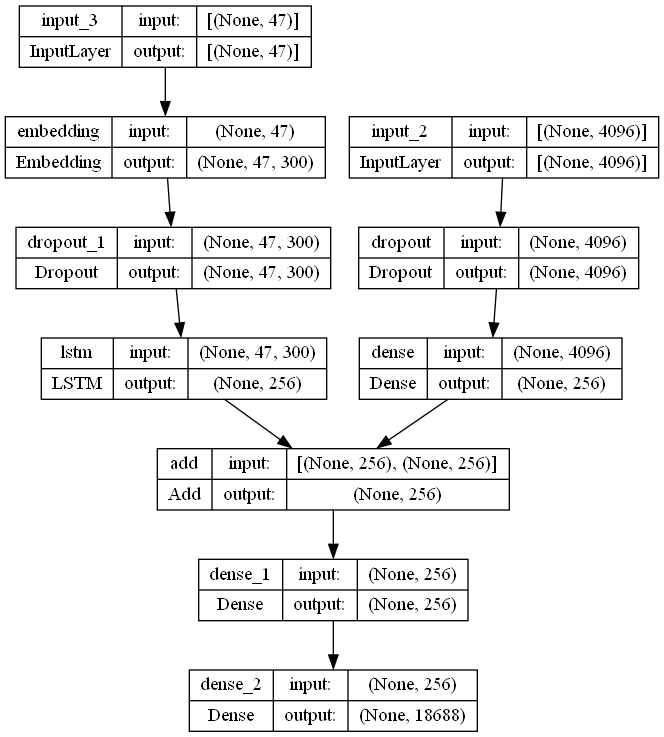

In [25]:
plot_model(captioning_model , show_shapes = True)

In [26]:
captioning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 47, 300)      5606400     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

## ***10-Checking GPU Power***

In [26]:
# making sure of the GPU power
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

## ***11-Model Training***

In [10]:
# Define a custom callback class to track the training loss history
class LossHistory(tf.keras.callbacks.Callback):

# Define a function to initialize the loss history list at the beginning of training
    def on_train_begin(self, logs={}):
        self.losses = []
    
# Define a function to append the training loss at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

In [33]:
model_loss = []

In [ ]:
steps = len(training_tokens) / 64

for i in range(50) :
  # shuffling training data before each epoch
  tokens_keys = list(training_tokens.keys())
  random.shuffle(tokens_keys)
  data = data_generator(tokens_keys,training_tokens,features,vocab_size,max_length,64)

  captioning_model.fit(data , epochs = 1 , steps_per_epoch=steps , verbose =1, callbacks=[history])

  # extracting epoch model loss and saving it into txt file
  loss = history.losses
  model_loss.append(loss[0])
  write_list_to_file(model_loss, 'model_loss.txt')

captioning_model.save('model_49.h5')

In [361]:
# loading txt file into list
def read_file_to_list(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

In [362]:
model_loss = read_file_to_list(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\saved_models\model_loss.txt")

## ***12-Inference using greedy algorithm***

In [311]:
captioning_model = tf.keras.models.load_model(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\saved_models\model_49.h5")

In [24]:
# importing saved TextVectorization layer
from_disk = pickle.load(open("tv_layer.pkl", "rb"))
vectorize_layer = TextVectorization.from_config(from_disk['config'])
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorize_layer.set_weights(from_disk['weights'])

# restoring vocab using TextVectorization layer
vocabulary = list(vectorize_layer.get_vocabulary())
vocab_size = vectorize_layer.vocabulary_size()

tf.Tensor([1], shape=(1,), dtype=int64)


In [ ]:
# loading saved fatures exctractor model
features_extractor = tf.keras.models.load_model(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\saved_models\features_extractor.h5")

In [ ]:
def get_features_from_image(image_path,model) :
  img = Image.open(image_path)
  img = img.resize((224,224))
  img = np.expand_dims(img,axis = 0)
  img = img/127.5
  img = img-1
  features = model.predict(img)
  return features

def get_word(index,vocab) :
  word = vocab[index]
  return word

In [25]:
def get_caption(path,features_extractor,vectorize_layer,captioning_model):
  my_features = get_features_from_image(path,features_extractor)
  caption = '<start>'
  for i in range(max_length) :
    sequenced_caption = vectorize_layer(tf.constant([caption])).numpy().tolist()
    padded_sequenced_caption = pad_sequences(sequenced_caption , maxlen = max_length, padding='post')[0]
    padded_sequenced_caption = np.resize(padded_sequenced_caption,(1,max_length))
    output = captioning_model.predict([my_features , padded_sequenced_caption])
    index = np.argmax(output)
    if index == 2 :
      caption = caption + ' <end>'
      return caption
    else :
      current_word = get_word(index,vocabulary)
      caption = caption + ' ' + current_word
  return caption

In [312]:
def get_caption_show_image(image_path=None) :
    if image_path is not None :
        image_path = image_path
    else :
        images_names = read_file(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\testing_images_list.txt")
        image_index = random.randint(0,len(images_names))
        image_path = os.path.join(r"C:\Era\apply cv\Masters\Semester 02\MP\image-caption-generator-master\flickr30k_images",images_names[image_index])

    caption = get_caption(image_path,features_extractor,vectorize_layer,captioning_model)[8:-5]
    print(caption)
    image = plt.imread(image_path)
    fig,ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')

    plt.show()

### ***12.1-Testing using random Images from testing set***

1/1 [==============================] - 0s 23ms/step
dog swims water 


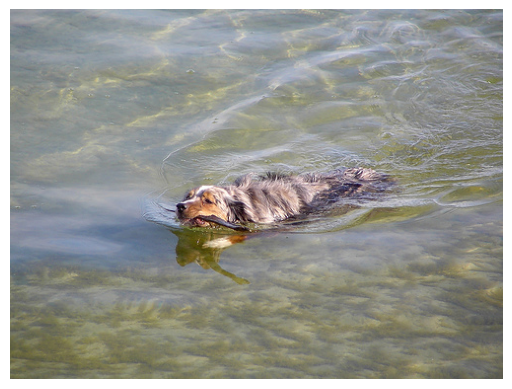

In [67]:
get_caption_show_image()

1/1 [==============================] - 0s 21ms/step
young boy wearing blue shirt playing tennis 


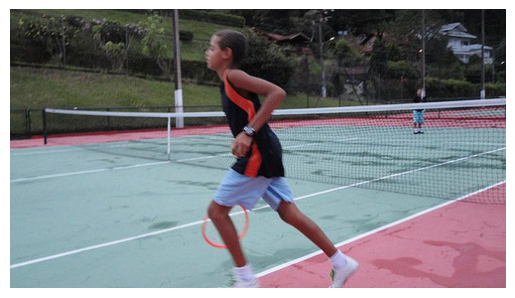

In [71]:
get_caption_show_image()

1/1 [==============================] - 0s 23ms/step
people walking street 


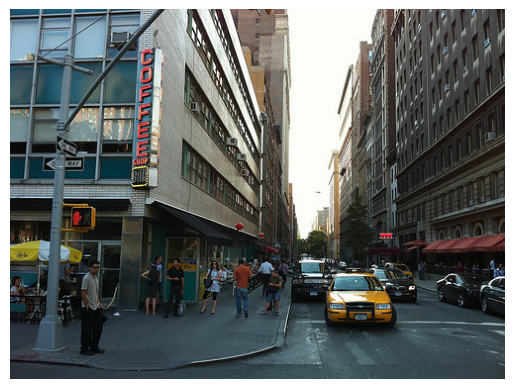

In [100]:
get_caption_show_image()

1/1 [==============================] - 0s 23ms/step
surfer riding wave 


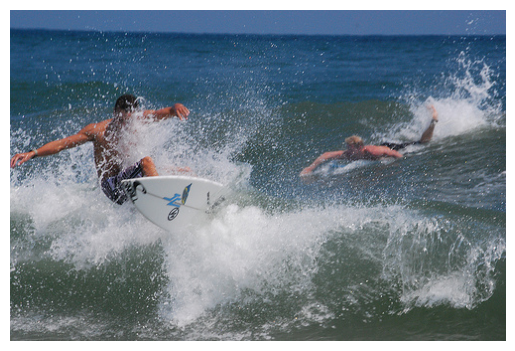

In [410]:
get_caption_show_image()

1/1 [==============================] - 0s 22ms/step
two men playing guitars stage 


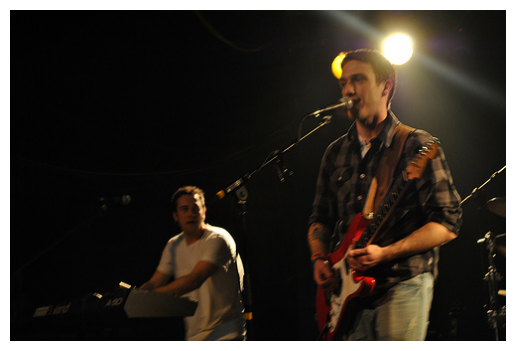

In [97]:
get_caption_show_image()

### ***12.2-Testing using Images downloaded from web***

1/1 [==============================] - 0s 19ms/step
two dogs playing together 


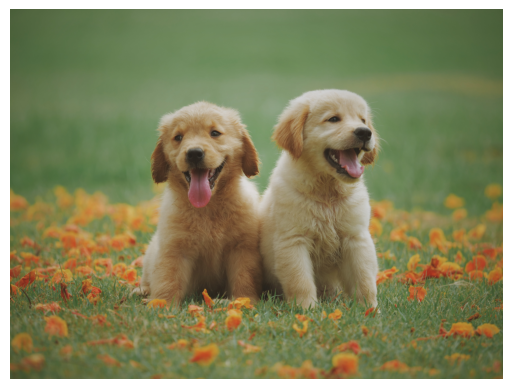

In [59]:
get_caption_show_image(r"C:\Users\User\Desktop\pexels-chevanon-photography-1108099.jpg")

1/1 [==============================] - 0s 21ms/step
two men playing soccer one trying tackle another trying tackle 


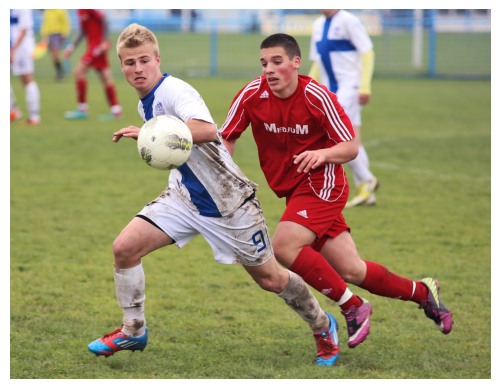

In [64]:
get_caption_show_image(r"C:\Users\User\Desktop\pexels-pixabay-2209.jpg")

1/1 [==============================] - 0s 21ms/step
basketball player shooting basketball 


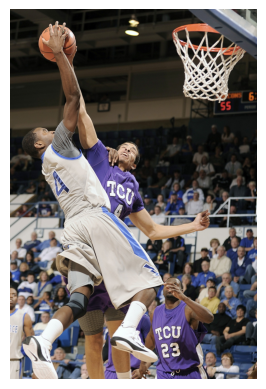

In [62]:
get_caption_show_image(r"C:\Users\User\Desktop\pexels-pixabay-2346.jpg")

1/1 [==============================] - 0s 19ms/step
group cyclists racing around curve track 


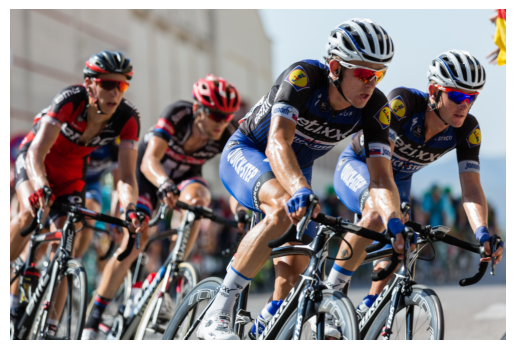

In [63]:
get_caption_show_image(r"C:\Users\User\Desktop\pexels-pixabay-248547.jpg")

1/1 [==============================] - 0s 23ms/step
man wearing black shirt black pants riding brown horse 


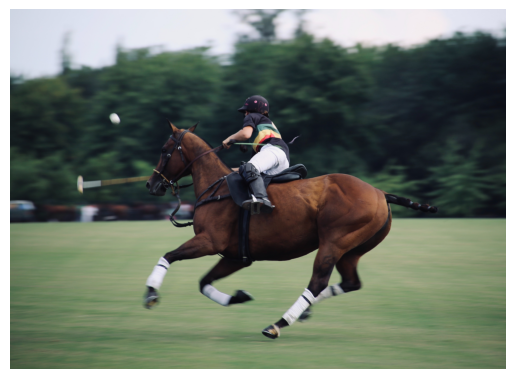

In [96]:
get_caption_show_image(r"C:\Users\User\Desktop\pexels-milena-de-narvaez-ayllon-2889030.jpg")

## ***13-Inference using beam search algorithm***

In [385]:
# getting top k probabilities and indexes
def get_word_preds(sentence,testing_image,beam_size) :
    sequenced_caption = vectorize_layer(tf.constant([sentence])).numpy().tolist()
    padded_sequenced_caption = pad_sequences(sequenced_caption , maxlen = max_length, padding='post')[0]
    padded_sequenced_caption = np.resize(padded_sequenced_caption,(1,max_length))
    preds = captioning_model.predict([testing_image , padded_sequenced_caption])
    word_preds_indexes = np.argsort(preds[0])[-beam_size:]
    return preds,word_preds_indexes

In [386]:
# getting top k captions using beam search algorithm
def get_caption_with_beam(image_path,beam_size) :

    # extracting image feature
    my_testing_image = get_features_from_image(image_path,features_extractor)

    cap = "<start>"
    current_k_sentences = {}
    final_captions = []
    new_hypotheses = []

   
    preds,word_preds_indexes = get_word_preds(cap,my_testing_image,beam_size)

    
    for w in word_preds_indexes:
        new_seq = [cap]
        new_seq.append(get_word(w,vocabulary))
        new_hypotheses.append((new_seq, preds[0][w]))

    
    new_hypotheses = sorted(new_hypotheses, key=lambda x: x[1], reverse=True)[:beam_size]
    for seq, prob in new_hypotheses:
        current_k_sentences[" ".join(seq)] = prob

    for _ in range(max_length-1) :
        all_sentences = []
        
        for sentence in current_k_sentences.keys() :
            # making sure the caption stops at "end" 
            if sentence[-3:] == "end" :
                final_captions.append((sentence,current_k_sentences[sentence]))
                beam_size = beam_size-1
                if beam_size == 0 :
                    break
                continue
            
            preds,word_preds_indexes = get_word_preds(sentence,my_testing_image,beam_size)

            new_hypotheses = []
        
            for w in word_preds_indexes:
                new_seq = [sentence]
                new_seq.append(get_word(w,vocabulary))
                new_hypotheses.append((new_seq, current_k_sentences[sentence]*preds[0][w]))

            new_hypotheses = sorted(new_hypotheses, key=lambda x: x[1], reverse=True)[:beam_size]
            
            for seq, prob in new_hypotheses:
                all_sentences.append((" ".join(seq),prob))

        
        all_sentences = sorted(all_sentences, key=lambda x: x[1], reverse=True)[:beam_size]
        current_k_sentences = {}
        for seq, prob in all_sentences:
            current_k_sentences["".join(seq)] = prob

        if beam_size == 0 :
            break
    
    # printing top k captions
    final_captions = sorted(final_captions, key=lambda x: x[1], reverse=True)
    for cap,prob in final_captions :
        print(cap[8:-4])
    
    # displaying testing image
    image = plt.imread(image_path)
    fig,ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')
    plt.show()

1/1 [==============================] - 0s 24ms/step
group children playing soccer
three children playing soccer
three boys playing soccer
group young boys playing soccer
group young boys play soccer
two children gleefully play soccer ball


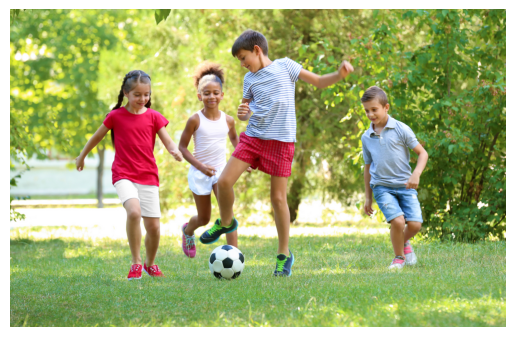

In [396]:
final_captions = get_caption_with_beam(r"C:\Users\User\Desktop\Kids-now-spend-twice-as-much-time-playing-indoors-than-outdoors.jpg",6)

1/1 [==============================] - 0s 21ms/step
man riding bike dirt road
person riding dirt bike
person riding bike dirt road
person riding dirt bike dirt course
man riding dirt bike dirt road
dirt bike rider riding dirt bike


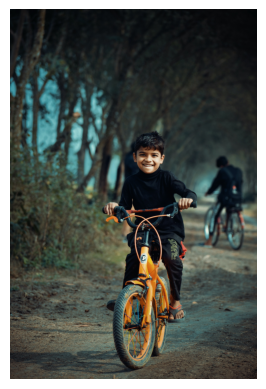

In [395]:
final_captions = get_caption_with_beam(r"C:\Users\User\Desktop\pexels-tarikul-raana-3619972.jpg",6)

## ***14-Visualizing Model Performance***

In [364]:
model_loss = [round(float(value),3) for value in model_loss ]

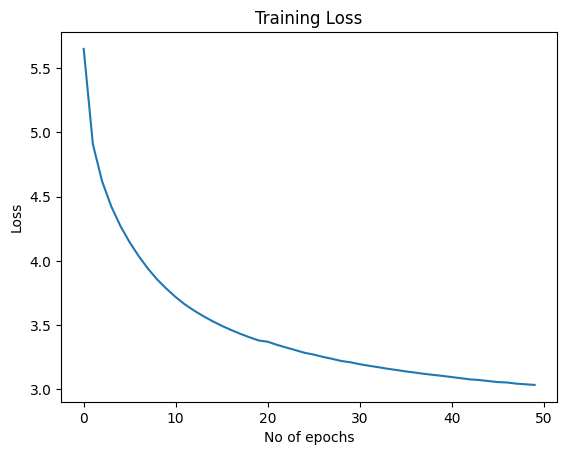

In [365]:
fig , ax = plt.subplots()
ax.plot(range(len(model_loss)),model_loss)
ax.set_xlabel("No of epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
plt.show()